In [1]:
import torch
import numpy as np
import librosa
import os

In [2]:
# create input audio
sampling_rate = 16000
seq_length = 10 * sampling_rate

filename = librosa.ex('brahms')
audio, sr = librosa.load(filename, sr=sampling_rate)
print('Original audio length (seconds):', len(audio) / sampling_rate)

n_chunk = len(audio) // seq_length
audio_chunks = []
audio_chunks = np.split(audio[: int(n_chunk * seq_length)], n_chunk)
audio_chunks.append(audio[-int(seq_length) :])
audio_chunks = torch.from_numpy(np.array(audio_chunks))
print('Input shape:', audio_chunks.shape)

Original audio length (seconds): 45.8449375
Input shape: torch.Size([5, 160000])


In [19]:
# create AST model
from models.ASTModel import AST
os.makedirs('../../pretrained_models/', exist_ok=True)
model = AST(n_class=10, reprog_front='skip', map_num=5)
ckpt_path = torch.load('../models/best_model.pth', 'cpu')
model.load_state_dict(ckpt_path)
model.eval()

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=1212


AST(
  (ast_mdl): WrappedModel(
    (module): ASTModel(
      (v): DistilledVisionTransformer(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (blocks): ModuleList(
          (0-11): 12 x Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=768, out_features=768, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (act): GELU(approximate='none')
              (fc2): Linear(in_feature

In [20]:
# predict output
output, ori_emb, transformed_emb = model(audio_chunks)
output = torch.sigmoid(output).detach().cpu().numpy()
ori_emb = ori_emb.detach().cpu().numpy()
transformed_emb = transformed_emb.detach().cpu().numpy()
print(output.shape, ori_emb.shape, transformed_emb.shape)

(5, 10) (5, 768) (5, 768)


In [21]:
# result
mapping = {
            0: "blues",
            1: "classical",
            2: "country",
            3: "disco",
            4: "hiphop",
            5: "jazz",
            6: "metal",
            7: "pop",
            8: "reggae",
            9: "rock",
        }

idx = np.argmax(output.mean(0), axis=0)
print('This song is predicted as:', mapping[idx])

This song is predicted as: classical


<Figure size 640x480 with 0 Axes>

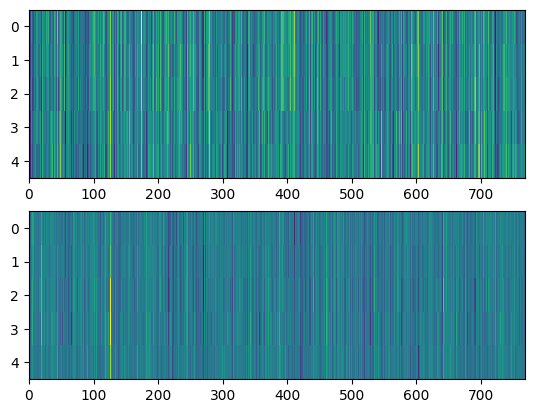

In [22]:
import matplotlib.pyplot as plt

plt.figure()
f, axarr = plt.subplots(2,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ori_emb, interpolation='nearest', aspect='auto')
axarr[1].imshow(transformed_emb, interpolation='nearest', aspect='auto')
